# Databao Feature Overview

Welcome! This notebook is a fast, beginner‑friendly tour of Databao. You will:

Notes:
- You need a DuckDB database at data/web_shop.duckdb (shipped with this example).
- Choose either OpenAI or local Ollama. Set your API key via an environment variable if you use OpenAI.


In [37]:
# Quick installs (safe to re-run)
!pip install -q duckdb databao matplotlib pandas seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [42]:
# Imports and DB connection
from pathlib import Path
import os
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Databao imports
import databao
from databao import LLMConfig

# Connect to the local DuckDB (read-only)
DB_PATH = "data/web_shop.duckdb"
conn = duckdb.connect(DB_PATH, read_only=False)
print(f"Connected to DuckDB database: {DB_PATH}")


Connected to DuckDB database: data/web_shop.duckdb


### 1) Choose your LLM (cloud or local)

Option A — Cloud (OpenAI)
- Requires environment variable OPENAI_API_KEY to be set in your shell/Jupyter.
- Example (Jupyter only): `%env OPENAI_API_KEY=YOUR_OPENAI_API_KEY`

Option B — Local (Ollama)
- Install Ollama and start it (`ollama serve`).
- Pull a model, e.g. `ollama pull qwen2.5:7b` or similar.

We’ll default to a cloud config below, but you can switch to the local config by uncommenting one line.


In [43]:
# Default: Cloud LLM (OpenAI). Low temperature helps produce stable SQL/plots.
llm_config = LLMConfig(name="gpt-4.1-2025-04-14", temperature=0)

# Alternative: Local LLM (uncomment to use your local Ollama config)
# llm_config = LLMConfig.from_yaml("../configs/qwen3-8b-ollama.yaml")


### 2) Open a Databao session and add your data sources

We’ll register:
- A database connection (DuckDB)
- A small context file (to help the model navigate your schema)
- An example pandas DataFrame (also with a short context)


In [44]:
session = databao.open_session(name="feature-overview", llm_config=llm_config)


# Register DuckDB with context
session.add_db(conn, context='context/duckdb_schema_overview.md')

# Also register an example DataFrame (not required, but shows how to add DFs)
cal = pd.DataFrame({
    "month": pd.date_range("2017-01-01", periods=6, freq="MS").strftime("%Y-%m"),
    "is_qtr_end": [False, False, True, False, False, True]
})

session.add_df(cal, name="calendar_helper", context="Small helper calendar with monthly rows and a qtr-end flag.")
print("Registered DBs:", list(session.dbs.keys()))
print("Registered DFs:", list(session.dfs.keys()))


Using context: dbt/target/manifest.json
Registered DBs: ['db1', 'duckdb']
Registered DFs: ['calendar_helper']


### 3) Start a thread and learn the core idea: .ask() is lazy

- .ask(prompt) queues your intent on the thread, but does not execute anything yet.
- Nothing runs until you call one of: .df() (materialize a DataFrame), .plot() (show a chart), .text() (narrative), or .code() (generated SQL/Python).


In [12]:
thread = session.thread()

# Queue a simple KPI request (still no execution yet)
thread.ask(
    """
    Return a compact KPI table with:
    - orders_count
    - total_revenue
    - average_order_value
    """
)
print("Nothing executed yet — execution is lazy.")

# Materialize results now
df_kpis = thread.df()
df_kpis


Nothing executed yet — execution is lazy.
======== <THINKING> ========

Let's break down the requirements and how to compute each KPI:

**Definitions:**
- **orders_count**: The total number of unique orders.
- **total_revenue**: The sum of all item prices (excluding freight) for all orders.
- **average_order_value**: The average revenue per order, calculated as total_revenue / orders_count.

**Approach:**
- Use the `web_shop.main.fct_sales` table, which contains one row per order item, with `order_id` and `item_price`.
- Aggregate:
  - Count distinct `order_id` for orders_count.
  - Sum `item_price` for total_revenue.
  - Divide total_revenue by orders_count for average_order_value.

Now, let's run the query.

[tool_call: 'run_sql_query']
```
{"sql":"SELECT \n  COUNT(DISTINCT order_id) AS orders_count,\n  SUM(item_price) AS total_revenue,\n  SUM(item_price) / COUNT(DISTINCT order_id) AS average_order_value\nFROM web_shop.main.fct_sales;"}
```


```sql
SELECT 
  COUNT(DISTINCT order_id)

,orders_count,total_revenue,average_order_value
0,565,673450.06,1191.947009


In [13]:
# Peek at the generated SQL/code for transparency
print(thread.code())


SELECT 
  COUNT(DISTINCT order_id) AS orders_count,
  SUM(item_price) AS total_revenue,
  SUM(item_price) / COUNT(DISTINCT order_id) AS average_order_value
FROM web_shop.main.fct_sales;


### 4) Thread memory: follow-ups can reference earlier results

The same thread remembers context. Ask a related question and it will use the prior computation as needed.


In [14]:
thread.ask("Add average delivery days and average review score to the KPI table. Keep it tidy.")
df_kpis_extended = thread.df()

======== <THINKING> ========

To add the requested KPIs:

**Definitions:**
- **average_delivery_days**: The average number of days between order purchase and delivery to customer, per order.
- **average_review_score**: The average review score for orders that have a review.

**Approach:**
- Use `web_shop.main.fct_sales` for order-level data.
- Join with `web_shop.main.dim_orders` to get `order_purchased_at` and `order_delivered_to_customer_at`.
- Join with `web_shop.main.dim_order_reviews` to get `review_score`.
- For each order, calculate delivery days as the difference in days between `order_delivered_to_customer_at` and `order_purchased_at`.
- Aggregate:
  - orders_count: COUNT(DISTINCT order_id)
  - total_revenue: SUM(item_price)
  - average_order_value: SUM(item_price) / COUNT(DISTINCT order_id)
  - average_delivery_days: AVG(delivery_days)
  - average_review_score: AVG(review_score) (only for orders with a review)

**Implementation:**
- Use subqueries or CTEs to ensure each order

,orders_count,total_revenue,average_order_value,average_delivery_days,average_review_score
0,565,673450.06,1191.947009,10.0925,3.406977


In [15]:
df_kpis_extended

,orders_count,total_revenue,average_order_value,average_delivery_days,average_review_score
0,565,673450.06,1191.947009,10.0925,3.406977


### 5) Chaining: .ask().ask().ask()

You can refine the same request by chaining .ask() calls before you materialize.

Tip: Use a new threads for topics that don’t build on the previous context.


In [47]:
second_thread = session.thread()
(
second_thread
    .ask("Compute monthly revenue for the last 6 months.")
    .ask("Include a 2-month moving average.")
    .ask("Name the columns month, revenue, revenue_ma2.")
)
df_trend = second_thread.df()


======== <THINKING> ========

To answer your question, here’s the step-by-step plan:

1. **Define "revenue"**: According to the metric definitions, revenue is the sum of item prices (excluding freight) from the fct_sales table.
2. **Determine the last 6 months**: We need to get the first day of the current month, go back 5 more months, and include all data from that month up to today.
3. **Aggregate by month**: Group the revenue by year and month.
4. **Order the results chronologically**.

Let’s proceed to write the query to get the monthly revenue for the last 6 months.



[tool_call: 'run_sql_query']
```
{"sql":"SELECT\n  strftime('%Y-%m', order_purchased_at) AS year_month,\n  SUM(item_price) AS revenue\nFROM web_shop.main.fct_sales\nWHERE order_purchased_at >= date_trunc('month', today()) - INTERVAL '5 months'\n  AND order_purchased_at < date_trunc('month', today()) + INTERVAL '1 month'\nGROUP BY year_month\nORDER BY year_month;"}
```


```sql
SELECT
  strftime('%Y-%m', order_purcha

In [18]:
second_thread = session.thread()

(
    second_thread
    .ask("Compute monthly revenue for the last 6 months.")
    .ask("Include a 2-month moving average.")
    .ask("Name the columns month, revenue, revenue_ma2.")
)
df_trend = second_thread.df()


======== <THINKING> ========

To answer your question, I will:

1. Define "monthly revenue": This is the sum of item_price for all order items, grouped by month.
2. Define the last 6 months: I will use the current date (2025-11-11) and select data from 2025-05-01 to 2025-10-31 (full months, as November is not complete yet).
3. Query the fct_sales table, grouping by year and month of order_purchased_at, and summing item_price.
4. Return the results ordered by month.

Let's proceed with the query.

[tool_call: 'run_sql_query']
```
{"sql":"SELECT\n  strftime('%Y-%m', order_purchased_at) AS year_month,\n  SUM(item_price) AS monthly_revenue\nFROM web_shop.main.fct_sales\nWHERE order_purchased_at >= date_trunc('month', date '2025-05-01')\n  AND order_purchased_at < date_trunc('month', date '2025-11-01')\nGROUP BY year_month\nORDER BY year_month;"}
```


```sql
SELECT
  strftime('%Y-%m', order_purchased_at) AS year_month,
  SUM(item_price) AS monthly_revenue
FROM web_shop.main.fct_sales
WHERE

In [20]:
# Quick visualization (Databao)
second_thread.plot("Line chart of revenue and revenue_ma2 by month")


VegaChatResult(text='<explain>\nNo filters are needed since the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This will allow the user to compare the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two lines.\n</explain>\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "line",\n  "encoding": {\n    "x": {\n      "field": "month",\n      "type": "temporal"\n    },\n    "y": {\n      "field": "value",\n      "type": "quantitative"\n    },\n    "color": {\n      "field": "variable",\n      "type": "nominal",\n      "title": "Metric"\n    }\n  },\n  "transform": [\n    {\n      "fold": ["revenue", "revenue_ma2"],\n      "as": ["variable", "value"]\n    }\n  ]\n}\n</json>\n', meta={'message': AIMessage(content=[{'type': 'text', 'text': '<explain>\nNo filters are needed since the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This will allow the user to compare the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two lines.\n</explain>\n<json>\n{\n  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",\n  "mark": "line",\n  "encoding": {\n    "x": {\n      "field": "month",\n      "type": "temporal"\n    },\n    "y": {\n      "field": "value",\n      "type": "quantitative"\n    },\n    "color": {\n      "field": "variable",\n      "type": "nominal",\n      "title": "Metric"\n    }\n  },\n  "transform": [\n    {\n      "fold": ["revenue", "revenue_ma2"],\n      "as": ["variable", "value"]\n    }\n  ]\n}\n</json>\n', 'annotations': []}], additional_kwargs={}, response_metadata={'id': 'resp_0b90a99158dc3c6f01691356d17af48197b82a84598729d382', 'created_at': 1762875089.0, 'metadata': {}, 'model': 'gpt-4.1-2025-04-14', 'object': 'response', 'service_tier': 'default', 'status': 'completed', 'model_name': 'gpt-4.1-2025-04-14'}, id='msg_0b90a99158dc3c6f01691356d21d8081979b69f9080f26ac1c', usage_metadata={'input_tokens': 1058, 'output_tokens': 259, 'total_tokens': 1317, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}), 'message_type': <MessageType.AI_RESPONSE_VALID: 'ai_response'>, 'spec': {'$schema': 'https://vega.github.io/schema/vega-lite/v5.json', 'mark': 'line', 'encoding': {'x': {'field': 'month', 'type': 'temporal'}, 'y': {'field': 'value', 'type': 'quantitative'}, 'color': {'field': 'variable', 'type': 'nominal', 'title': 'Metric'}}, 'transform': [{'fold': ['revenue', 'revenue_ma2'], 'as': ['variable', 'value']}]}, 'is_spec_fixed': False, 'is_empty_chart': False, 'is_valid_schema': True, 'is_drawable': True, 'model_response': {'specs': [{'$schema': 'https://vega.github.io/schema/vega-lite/v5.json', 'mark': 'line', 'encoding': {'x': {'field': 'month', 'type': 'temporal'}, 'y': {'field': 'value', 'type': 'quantitative'}, 'color': {'field': 'variable', 'type': 'nominal', 'title': 'Metric'}}, 'transform': [{'fold': ['revenue', 'revenue_ma2'], 'as': ['variable', 'value']}]}], 'explanation': 'No filters are needed since the user wants to see all available data. The best chart type for showing two quantitative variables over time is a line chart. Both "revenue" and "revenue_ma2" should be plotted as separate lines, with "month" on the x-axis. This will allow the user to compare the actual revenue and its 2-month moving average over time. No data transformation is necessary beyond mapping the fields to the appropriate axes and using color to distinguish the two li

### 6) Insights: ask for a short narrative and read it via .text()


In [21]:
second_thread.ask("Write 3 bullet insights about the revenue trend you just computed. Keep it concise.")
print(second_thread.text())


======== <THINKING> ========

- Revenue peaked in July 2025 at 179,467, then declined steadily through September 2025.
- The 2-month moving average closely follows the monthly revenue, indicating a consistent downward trend after July.
- By September 2025, revenue dropped to 162,770, the lowest in the observed period, suggesting a potential need for intervention or further analysis.
======== </THINKING> ========

- Revenue peaked in July 2025 at 179,467, then declined steadily through September 2025.
- The 2-month moving average closely follows the monthly revenue, indicating a consistent downward trend after July.
- By September 2025, revenue dropped to 162,770, the lowest in the observed period, suggesting a potential need for intervention or further analysis.


### 7) Use the DataFrame yourself (pandas / seaborn)

The DataFrame returned by .df() is just a normal pandas DataFrame. You can use it anywhere.


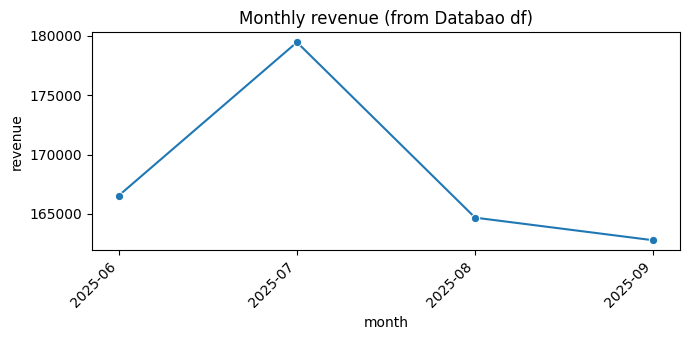

In [29]:
if {"month", "revenue"}.issubset(df_trend.columns):
    import seaborn as sns
    plt.figure(figsize=(7, 3.5))
    sns.lineplot(data=df_trend, x="month", y="revenue", marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.title("Monthly revenue (from Databao df)")
    plt.tight_layout()
    plt.show()
else:
    print("df_trend columns:", df_trend.columns.tolist(), "— adjust the plotting code to your column names.")


### Wrap up

- You saw how to set up a session, add a DB and a DataFrame, and provide context (dbt manifest or a tiny generated file).
- .ask() is lazy — results appear only after .df()/.plot()/.text()/.code().
- Keep connected questions in the same thread; use a fresh thread for unrelated topics.
- You can chain .ask() calls to refine an instruction before executing.
- Pull insights with .text() and reuse DataFrames in your own code.


In [32]:
# Close the database connection when done
conn.close()
print("Database connection closed successfully!")


Database connection closed successfully!
